# EDA: Accelerometer Action Classification
This notebook contains basic EDA for the provided CSVs.

Loaded 15 files; total rows = 1926896


,seq,x,y,z,label,participant
0,0.0,1502,2215,2153,1,1
1,1.0,1667,2072,2047,1,1
2,2.0,1611,1957,1906,1,1
3,3.0,1601,1939,1831,1,1
4,4.0,1643,1965,1879,1,1


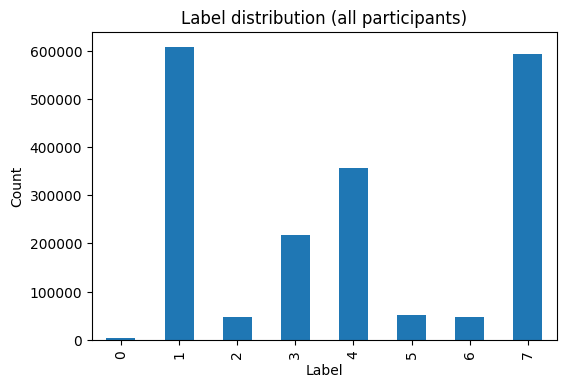

In [1]:
import os
import pandas as pd, glob, matplotlib.pyplot as plt

data_dir = r"/home/minorilabs/Desktop/Practice/assigm/Human-Action-Classification/data"
files = sorted(glob.glob(os.path.join(data_dir, '*.csv')))
dfs = [pd.read_csv(f, header=None, names=['seq','x','y','z','label']).assign(participant=os.path.basename(f).split('.')[0]) for f in files]

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print('Loaded', len(files), 'files; total rows =', len(df))
    display(df.head())

    # label distribution
    plt.figure(figsize=(6,4))
    df['label'].value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Label'); plt.ylabel('Count'); plt.title('Label distribution (all participants)')
    plt.show()
else:
    print(f"No CSV files found in '{data_dir}' directory.")

In [ ]:
# Get all rows with label 0
label_0_rows = df[df['label'] == 0]

if not label_0_rows.empty:
    print(f"Found {len(label_0_rows)} rows with label 0 across all files")
    
    # Display all rows with label 0
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(label_0_rows)
    
    # Show distribution by participant
    plt.figure(figsize=(10,4))
    label_0_rows['participant'].value_counts().plot(kind='bar')
    plt.title('Label 0 Distribution by Participant')
    plt.xlabel('Participant')
    plt.ylabel('Count')
    plt.show()
else:
    print("No rows found with label 0 in any files")

Label 0 percentage: 0.00% (0 out of 1923177 rows)

Label distribution percentages:
label
1    31.649037
2     2.489526
3    11.269738
4    18.566362
5     2.677757
6     2.483911
7    30.863670
Name: proportion, dtype: float64


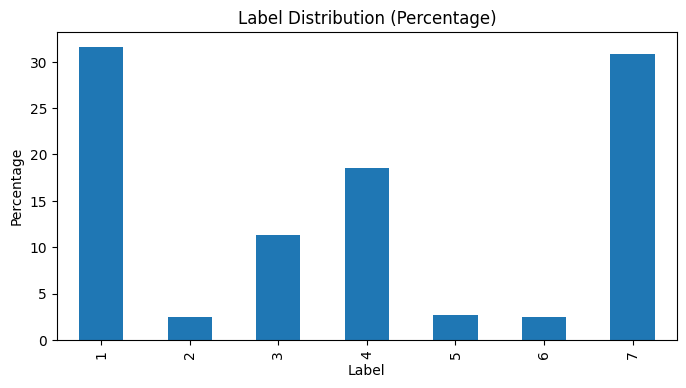

In [7]:
# Calculate percentage of label 0
label_0_count = len(df[df['label'] == 0])
total_count = len(df)
percentage = (label_0_count / total_count) * 100

print(f"Label 0 percentage: {percentage:.2f}% ({label_0_count} out of {total_count} rows)")

# Show distribution of all labels
label_distribution = df['label'].value_counts(normalize=True) * 100
print("\nLabel distribution percentages:")
print(label_distribution.sort_index())

# Visualize the distribution
plt.figure(figsize=(8,4))
label_distribution.sort_index().plot(kind='bar')
plt.title('Label Distribution (Percentage)')
plt.xlabel('Label')
plt.ylabel('Percentage')
plt.show()

In [8]:
# Get count of label 0 rows before dropping
label_0_count = len(df[df['label'] == 0])

# Drop rows where label == 0
df = df[df['label'] != 0]

# Verify the removal
print(f"Dropped {label_0_count} rows with label 0")
print(f"Remaining rows: {len(df)}")
print("New label distribution:")
print(df['label'].value_counts())

# Optional: Save the filtered data
df.to_csv('filtered_data.csv', index=False)
print("Saved filtered data to filtered_data.csv")

Dropped 0 rows with label 0
Remaining rows: 1923177
New label distribution:
label
1    608667
7    593563
4    357064
3    216737
5     51498
2     47878
6     47770
Name: count, dtype: int64
Saved filtered data to filtered_data.csv


In [9]:
print(df.isnull().sum())
print("Any NaNs?", df.isnull().values.any())
print("Describe:", df.describe())

seq            0
x              0
y              0
z              0
label          0
participant    0
dtype: int64
Any NaNs? False
Describe:                 seq             x             y             z         label
count  1.923177e+06  1.923177e+06  1.923177e+06  1.923177e+06  1.923177e+06
mean   6.715608e+04  1.987479e+03  2.382300e+03  1.970488e+03  3.890407e+00
std    4.148245e+04  1.113408e+02  1.002107e+02  9.449121e+01  2.439785e+00
min    0.000000e+00  2.820000e+02  2.000000e+00  1.000000e+00  1.000000e+00
25%    3.205200e+04  1.904000e+03  2.337000e+03  1.918000e+03  1.000000e+00
50%    6.433400e+04  1.992000e+03  2.367000e+03  1.988000e+03  4.000000e+00
75%    9.844000e+04  2.076000e+03  2.412000e+03  2.032000e+03  7.000000e+00
max    1.667400e+05  3.828000e+03  4.095000e+03  4.095000e+03  7.000000e+00


#  Visualize Feature Distributions

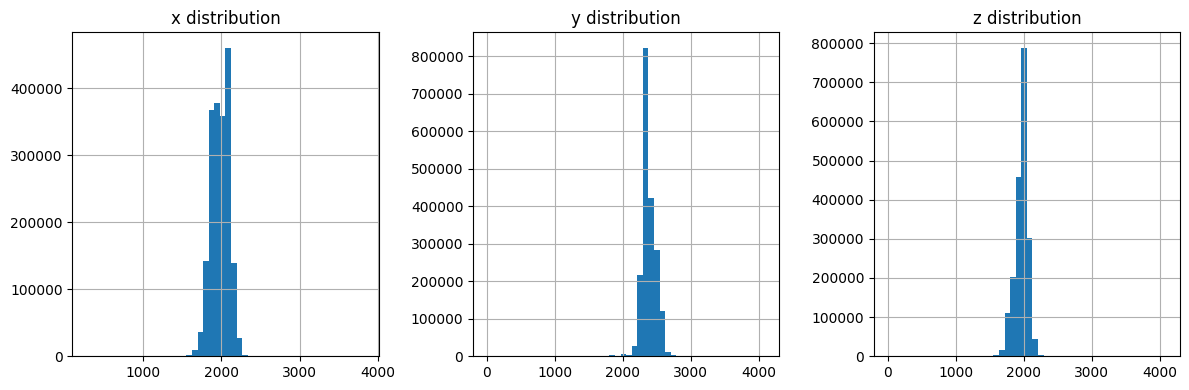

In [10]:
plt.figure(figsize=(12,4))
for i, col in enumerate(['x','y','z']):
    plt.subplot(1,3,i+1)
    df[col].hist(bins=50)
    plt.title(f'{col} distribution')
plt.tight_layout()
plt.show()

# Visualize Sample Windows for Different Actions

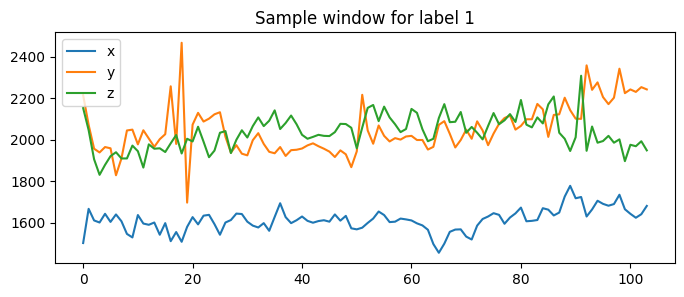

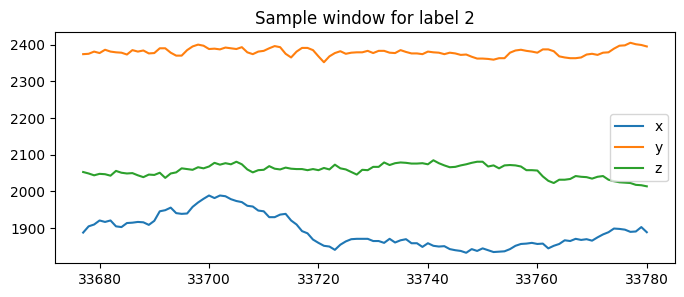

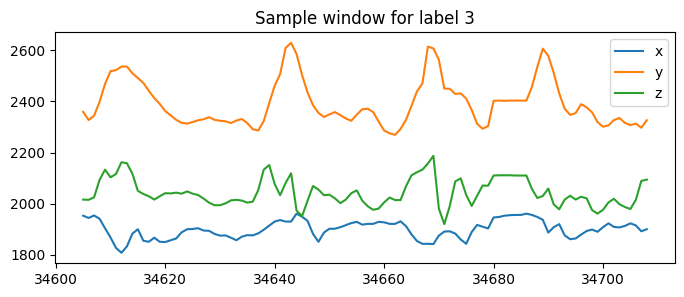

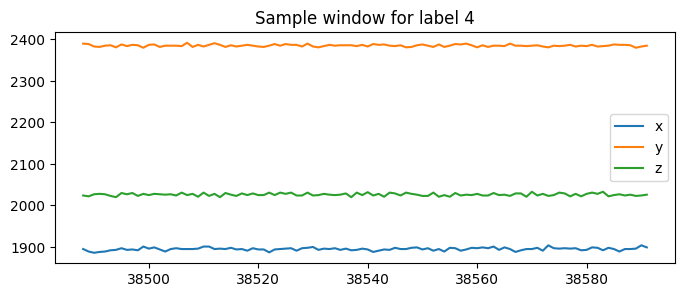

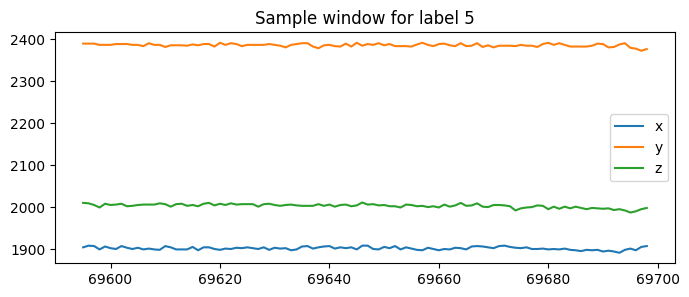

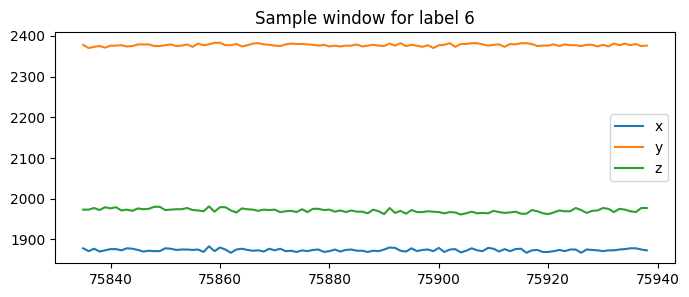

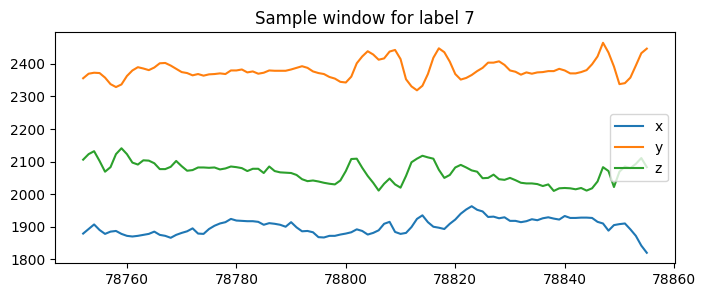

In [11]:
for label in sorted(df['label'].unique()):
    sample = df[df['label']==label].head(104)
    plt.figure(figsize=(8,3))
    plt.plot(sample['x'], label='x')
    plt.plot(sample['y'], label='y')
    plt.plot(sample['z'], label='z')
    plt.title(f'Sample window for label {label}')
    plt.legend()
    plt.show()

# Correlation Analysis

          x         y         z
x  1.000000  0.363657  0.009827
y  0.363657  1.000000  0.345655
z  0.009827  0.345655  1.000000


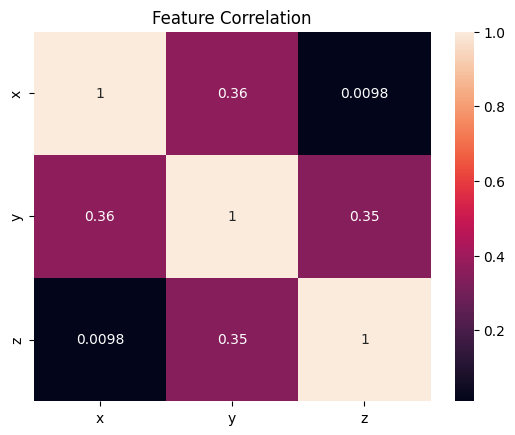

In [12]:
corr = df[['x','y','z']].corr()
print(corr)
import seaborn as sns
sns.heatmap(corr, annot=True)
plt.title('Feature Correlation')
plt.show()

#  Label Mapping

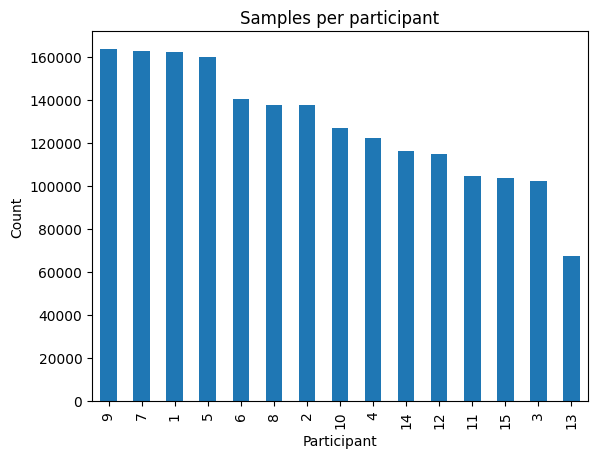

In [13]:
df['participant'].value_counts().plot(kind='bar')
plt.title('Samples per participant')
plt.xlabel('Participant')
plt.ylabel('Count')
plt.show()

In [14]:
for col in ['x', 'y', 'z']:
    print(f"{col} outliers:", df[(df[col] < df[col].quantile(0.01)) | (df[col] > df[col].quantile(0.99))].shape[0])

x outliers: 38202
y outliers: 38249
z outliers: 38212


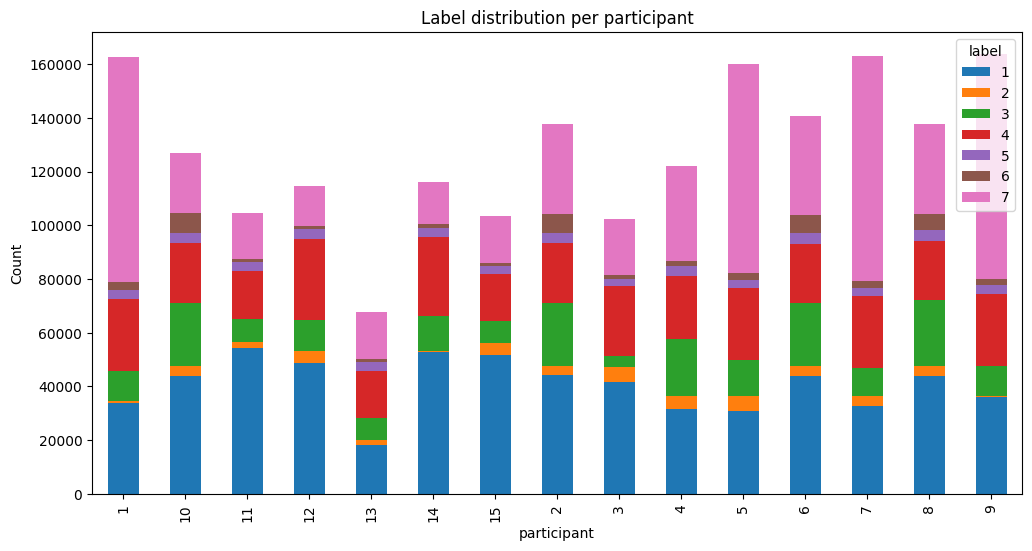

In [15]:
pd.crosstab(df['participant'], df['label']).plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Label distribution per participant')
plt.ylabel('Count')
plt.show()

In [16]:
print(df['label'].unique())

[1 2 3 4 5 6 7]


In [17]:
df['label'] = df['label'].astype(str)

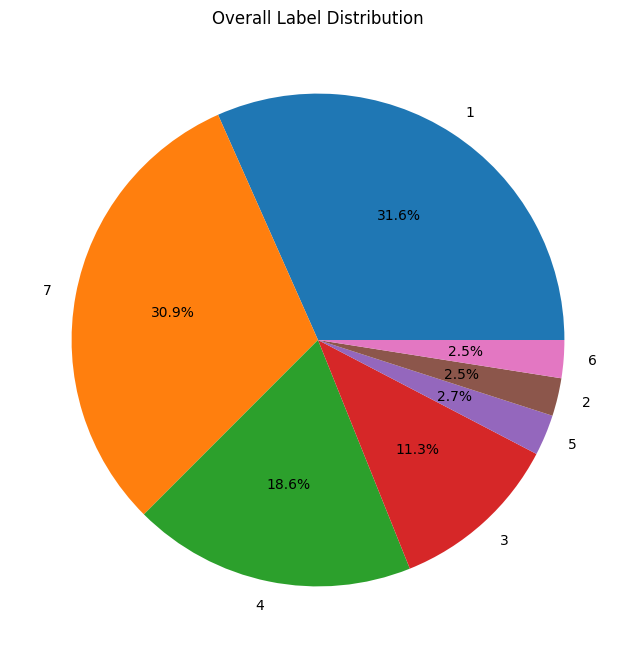

In [18]:
df['label'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(8,8))
plt.title('Overall Label Distribution')
plt.ylabel('')
plt.show()

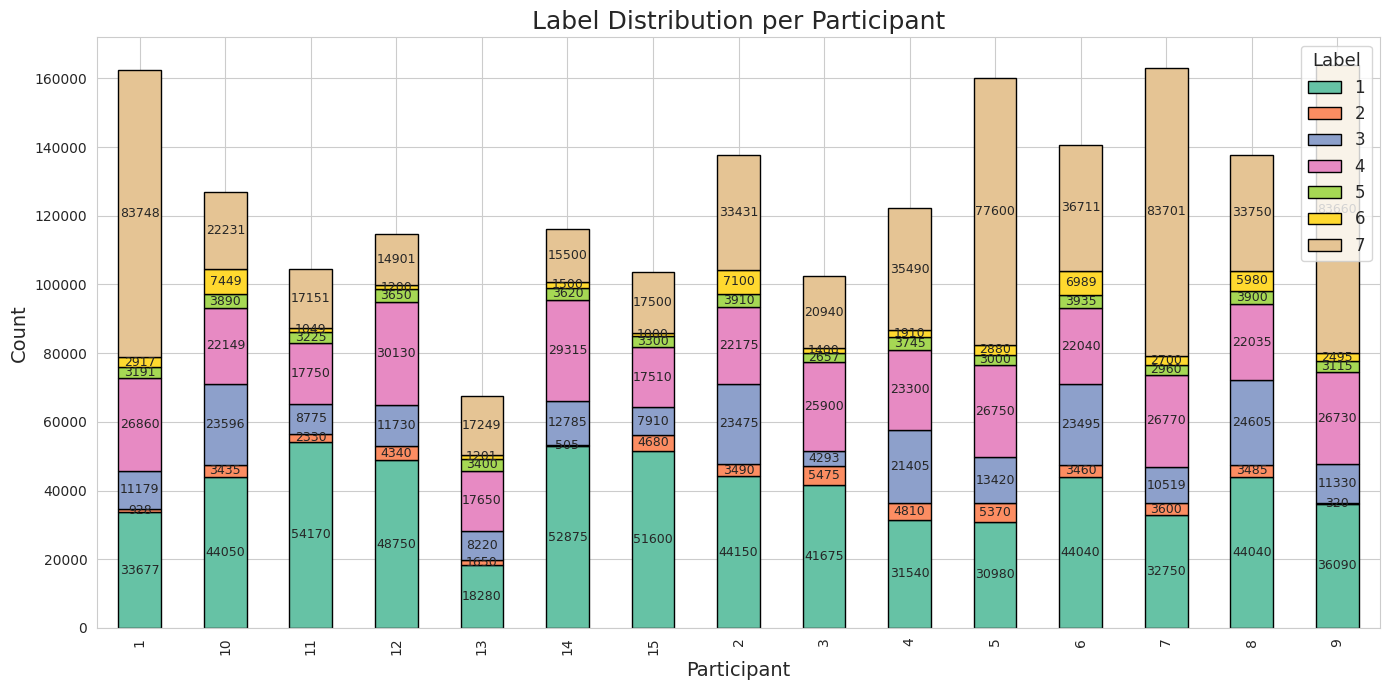

In [19]:
# ... existing code ...
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style
sns.set_style("whitegrid")

# Create the crosstab
ct = pd.crosstab(df['participant'], df['label'])

# Choose a color palette
colors = sns.color_palette("Set2", n_colors=ct.shape[1])

# Plot
ax = ct.plot(kind='bar', stacked=True, figsize=(14, 7), color=colors, edgecolor='black')

# Add value annotations
for c in ax.containers:
    ax.bar_label(c, label_type='center', fontsize=9)

plt.title('Label Distribution per Participant', fontsize=18)
plt.xlabel('Participant', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Label', fontsize=12, title_fontsize=13, loc='upper right')
plt.tight_layout()
plt.show()
# ... existing code ...

1. Summarize EDA Insights
No missing values: Data is clean.
Feature distributions: x, y, z are roughly normal, but check for outliers.
Label imbalance: Some actions (labels 1 and 7) dominate; others are underrepresented.
Participant imbalance: Some participants have much more data.
Feature correlation: Moderate correlation between axes.
Outliers: Each axis has ~38,000 outliers (about 2% of data).

2. Recommendations for Modeling
A. Handle Outliers
Consider removing or capping outliers, or use robust scaling (e.g., StandardScaler, RobustScaler).
You can filter out rows outside the 1st and 99th percentiles for each axis.
B. Address Class Imbalance
Use stratified sampling for train/test split.
Consider class weights in your model (RandomForest supports class_weight='balanced').
Optionally, try oversampling minority classes (e.g., SMOTE) if performance is poor.


3. Next Steps 
Preprocessing:
Remove or cap outliers.
Normalize or scale features.


After outlier removal, shape: (1825880, 6)


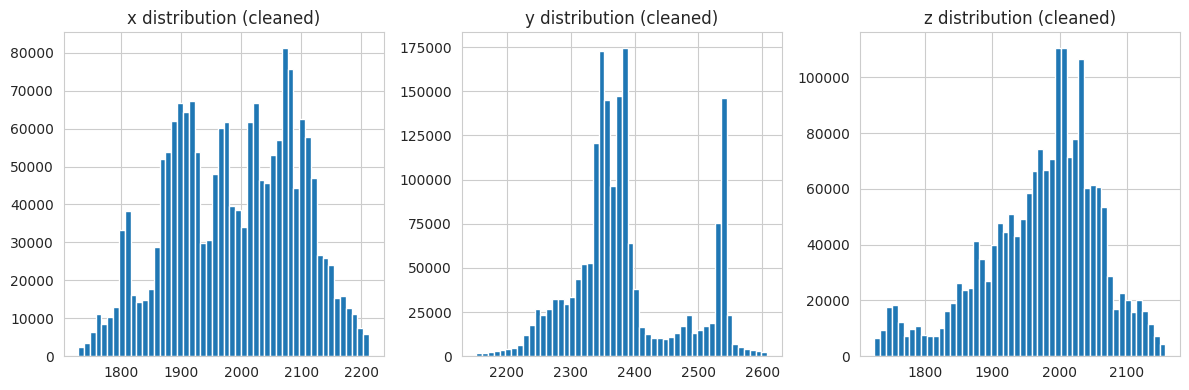

In [20]:
# Step 1: Calculate thresholds
outlier_limits = {}
for col in ['x', 'y', 'z']:
    outlier_limits[col] = (df[col].quantile(0.01), df[col].quantile(0.99))

# Step 2: Filter out outliers
for col in ['x', 'y', 'z']:
    lower, upper = outlier_limits[col]
    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("After outlier removal, shape:", df.shape)

# Step 3: Visualize distributions again (optional)
plt.figure(figsize=(12,4))
for i, col in enumerate(['x','y','z']):
    plt.subplot(1,3,i+1)
    df[col].hist(bins=50)
    plt.title(f'{col} distribution (cleaned)')
plt.tight_layout()
plt.show()

In [21]:
import numpy as np

# Pre-Processing and Feature Engineering

In [22]:
df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)

# Normalize or Scale Features

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['x', 'y', 'z', 'magnitude']] = scaler.fit_transform(df[['x', 'y', 'z', 'magnitude']])

# Split Data for Training and Testing

In [24]:
from sklearn.model_selection import train_test_split

X = df[['x', 'y', 'z', 'magnitude']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      0.86      0.86    115562
           2       0.26      0.26      0.26      8733
           3       0.52      0.44      0.48     41815
           4       0.61      0.68      0.64     63932
           5       0.25      0.18      0.21      9499
           6       0.32      0.26      0.29      9440
           7       0.75      0.78      0.77    116195

    accuracy                           0.71    365176
   macro avg       0.51      0.49      0.50    365176
weighted avg       0.70      0.71      0.70    365176

[[98832  4488  1881  4266   374   296  5425]
 [ 2537  2275   611  1813    58    56  1383]
 [ 2153   395 18358  8349  2141  1172  9247]
 [ 4376   483  5119 43759   772   461  8962]
 [  695    42  1430  3548  1723   365  1696]
 [  347    62   962  1802   502  2458  3307]
 [ 4937   902  6757  8519  1250  2848 90982]]


In [54]:
import joblib

joblib.dump(model, 'random_forest_model.joblib')
print("Model saved to random_forest_model.joblib")

Model saved to random_forest_model.joblib


# Due to class imbalance testing out StratifiedKFold

In [52]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(class_weight='balanced', random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_pred = model.predict(X.iloc[test_idx])
    print(f"\nFold {fold} classification report:")
    print(classification_report(y.iloc[test_idx], y_pred))


Fold 1 classification report:
              precision    recall  f1-score   support

           1       0.87      0.85      0.86    115562
           2       0.26      0.26      0.26      8733
           3       0.52      0.44      0.48     41815
           4       0.61      0.69      0.64     63932
           5       0.26      0.18      0.22      9499
           6       0.32      0.26      0.29      9441
           7       0.75      0.78      0.77    116194

    accuracy                           0.71    365176
   macro avg       0.51      0.49      0.50    365176
weighted avg       0.70      0.71      0.70    365176


Fold 2 classification report:
              precision    recall  f1-score   support

           1       0.87      0.86      0.86    115562
           2       0.26      0.26      0.26      8733
           3       0.52      0.44      0.48     41815
           4       0.61      0.69      0.64     63932
           5       0.25      0.18      0.21      9499
           6    

# Tuning Model Parameters using GridSearchCV

In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    rf, param_grid, cv=skf, scoring='f1_weighted', n_jobs=-1, verbose=2
)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated F1 (weighted):", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=12.0min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=12.1min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=12.1min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=12.1min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=12.1min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=12.1min
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=12.2min
[CV] END class_weight=balanced, max_depth=None, min_samp

/home/minorilabs/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=10.9min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=11.0min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=11.0min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=11.1min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=10.7min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=10.9min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=10.5min
[CV] END class_weight=balanced, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=10.6min
[CV] END

In [54]:
print(y.value_counts())

label
7    580974
1    577810
4    319659
3    209074
5     47495
6     47203
2     43665
Name: count, dtype: int64


In [55]:
print(df.isnull().sum())

seq            0
x              0
y              0
z              0
label          0
participant    0
magnitude      0
dtype: int64


# Synthetic Minority Oversampling Technique (SMOTE) to generate synthetic samples for minority classes.

In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [27]:
from sklearn.model_selection import train_test_split

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model on the resampled training data
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.84      0.85    116194
           2       0.87      0.89      0.88    116195
           3       0.75      0.72      0.74    116195
           4       0.73      0.74      0.73    116195
           5       0.83      0.86      0.84    116195
           6       0.86      0.87      0.86    116195
           7       0.76      0.73      0.75    116195

    accuracy                           0.81    813364
   macro avg       0.81      0.81      0.81    813364
weighted avg       0.81      0.81      0.81    813364

Accuracy: 0.8075707801181267
[[ 98061   5011   2293   3926   1329    781   4793]
 [  3512 103679   1782   3340   1264    901   1717]
 [  2390   2497  83698   9069   6133   3873   8535]
 [  3879   3767   7708  85564   5599   3341   6337]
 [  1200   1204   4380   4807  99527   3017   2060]
 [   777   1070   2741   3341   3603 101499   3164]
 [  4332   2539   8459   7834   3045   

In [33]:
import os,joblib

# Create the directory if it doesn't exist
os.makedirs('models', exist_ok=True)
# Save the model to the 'models' directory
joblib.dump(model, 'models/Final_model.pkl')

print("Final model saved in the 'models/' directory as 'Final_model.pkl'")


Final model saved in the 'models/' directory as 'Final_model.pkl'


In [35]:
# Load the model from the file
loaded_model = joblib.load('models/Final_model.pkl')

# Use the loaded model to make predictions
y_pred_loaded = loaded_model.predict(X_test)

# Print predictions
print("Predictions from the loaded model:", y_pred_loaded[:10])  # Print first 10 predictions for brevity

Predictions from the loaded model: ['4' '3' '4' '5' '7' '4' '2' '4' '7' '3']


In [36]:
import joblib
from pathlib import Path

# Path to the old model
old_model_path = Path('models/Final_model.pkl')

# Path to save the new model
new_model_path = Path('models/Final_model.joblib')

# Load the model with the old version of scikit-learn
model = joblib.load(old_model_path)

# Save the model with the current version of scikit-learn
joblib.dump(model, new_model_path)

print(f"Model re-saved to {new_model_path}")

Model re-saved to models/Final_model.joblib


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(class_weight='balanced', random_state=42)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    y_pred = model.predict(X.iloc[test_idx])
    print(f"\nFold {fold} classification report:")
    print(classification_report(y.iloc[test_idx], y_pred))
    print(confusion_matrix(y_test, y_pred))
    

In [61]:
!pip install xgboost lightgbm catboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 66.6 MB/s eta 0:00:00:00:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.8/412.8 KB 60.8 MB/s eta 0:00:00


In [62]:
from sklearn.model_selection import train_test_split

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [64]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Adjust labels to start from 0
y_train = y_train - 1
y_test = y_test - 1

# Initialize the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))

/home/minorilabs/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:16:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77    116194
           1       0.64      0.61      0.62    116195
           2       0.58      0.46      0.51    116195
           3       0.47      0.58      0.52    116195
           4       0.51      0.54      0.53    116195
           5       0.67      0.55      0.60    116195
           6       0.62      0.66      0.64    116195

    accuracy                           0.60    813364
   macro avg       0.61      0.60      0.60    813364
weighted avg       0.61      0.60      0.60    813364

XGBoost Accuracy: 0.6000708170019818


In [65]:
from lightgbm import LGBMClassifier

# Initialize the LightGBM model
lgbm_model = LGBMClassifier(random_state=42)

# Train the model
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred = lgbm_model.predict(X_test)

# Evaluate the model
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred))
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 3253454, number of used features: 4
[LightGBM] [Info] Start training from score -1.945908
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77    116194
           1       0.63      0.61      0.62    116195
           2       0.57      0.46      0.51    116195
           3       

In [66]:
from catboost import CatBoostClassifier

# Initialize the CatBoost model
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions
y_pred = catboost_model.predict(X_test)

# Evaluate the model
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred))
print("CatBoost Accuracy:", accuracy_score(y_test, y_pred))

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79    116194
           1       0.65      0.63      0.64    116195
           2       0.58      0.46      0.51    116195
           3       0.47      0.56      0.51    116195
           4       0.51      0.55      0.53    116195
           5       0.66      0.56      0.60    116195
           6       0.65      0.69      0.67    116195

    accuracy                           0.61    813364
   macro avg       0.61      0.61      0.61    813364
weighted avg       0.61      0.61      0.61    813364

CatBoost Accuracy: 0.6087999960657221


In [68]:
from sklearn.model_selection import cross_val_score

# Example with XGBoost
xgb_scores = cross_val_score(xgb_model, X_resampled, y_resampled-1, cv=5, scoring='f1_weighted')
print("XGBoost Cross-Validation F1 Scores:", xgb_scores)
print("XGBoost Mean F1 Score:", xgb_scores.mean())

/home/minorilabs/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:28:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/minorilabs/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:29:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/minorilabs/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:30:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/minorilabs/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [09:31:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/minorilabs/.local/lib/python3.10/site-pack

XGBoost Cross-Validation F1 Scores: [0.3649309  0.42166298 0.42725109 0.46478709 0.44788541]
XGBoost Mean F1 Score: 0.42530349331332146


#   Trying out Neural Network based Models Now

In [70]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Split the scaled data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.3),
    Dense(y_train_onehot.shape[1], activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

2025-10-09 09:33:35.488347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759982615.682807 1110272 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759982615.739004 1110272 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759982616.130140 1110272 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759982616.130170 1110272 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759982616.130173 1110272 computation_placer.cc:177] computation placer alr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,416 (36.78 KB)

 Trainable params: 9,416 (36.78 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
# Train the model
history = model.fit(X_train, y_train_onehot, validation_data=(X_test, y_test_onehot), epochs=20, batch_size=32)

Epoch 1/20
101671/101671 ━━━━━━━━━━━━━━━━━━━━ 343s 3ms/step - accuracy: 0.4505 - loss: 1.4549 - val_accuracy: 0.5157 - val_loss: 1.3053
Epoch 2/20
101671/101671 ━━━━━━━━━━━━━━━━━━━━ 339s 3ms/step - accuracy: 0.4757 - loss: 1.3965 - val_accuracy: 0.5209 - val_loss: 1.2831
Epoch 3/20
101671/101671 ━━━━━━━━━━━━━━━━━━━━ 339s 3ms/step - accuracy: 0.4802 - loss: 1.3849 - val_accuracy: 0.5265 - val_loss: 1.2751
Epoch 4/20
101671/101671 ━━━━━━━━━━━━━━━━━━━━ 339s 3ms/step - accuracy: 0.4819 - loss: 1.3793 - val_accuracy: 0.5235 - val_loss: 1.2706
Epoch 5/20
101671/101671 ━━━━━━━━━━━━━━━━━━━━ 341s 3ms/step - accuracy: 0.4839 - loss: 1.3754 - val_accuracy: 0.5247 - val_loss: 1.2672
Epoch 6/20
101671/101671 ━━━━━━━━━━━━━━━━━━━━ 340s 3ms/step - accuracy: 0.4853 - loss: 1.3721 - val_accuracy: 0.5239 - val_loss: 1.2631
Epoch 7/20
101671/101671 ━━━━━━━━━━━━━━━━━━━━ 339s 3ms/step - accuracy: 0.4861 - loss: 1.3700 - val_accuracy: 0.5301 - val_loss: 1.2567
Epoch 8/20
101671/101671 ━━━━━━━━━━━━━━━━━━━━ 33

In [73]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print("Test Accuracy:", test_accuracy)

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

25418/25418 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - accuracy: 0.5346 - loss: 1.2493
Test Accuracy: 0.534622848033905
25418/25418 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.75      0.68    116194
           2       0.58      0.50      0.54    116195
           3       0.54      0.36      0.43    116195
           4       0.41      0.57      0.48    116195
           5       0.45      0.47      0.46    116195
           6       0.64      0.47      0.54    116195
           7       0.56      0.62      0.59    116195

    accuracy                           0.53    813364
   macro avg       0.54      0.53      0.53    813364
weighted avg       0.54      0.53      0.53    813364



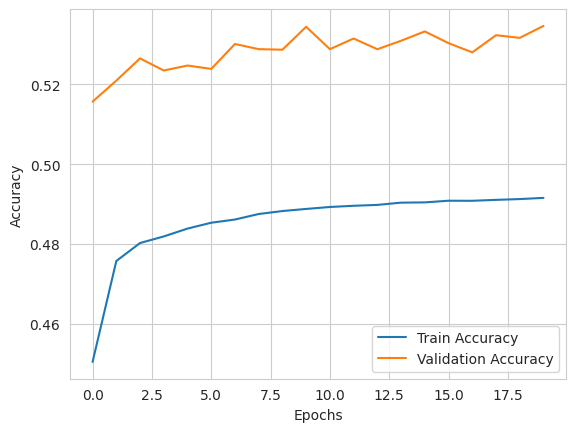

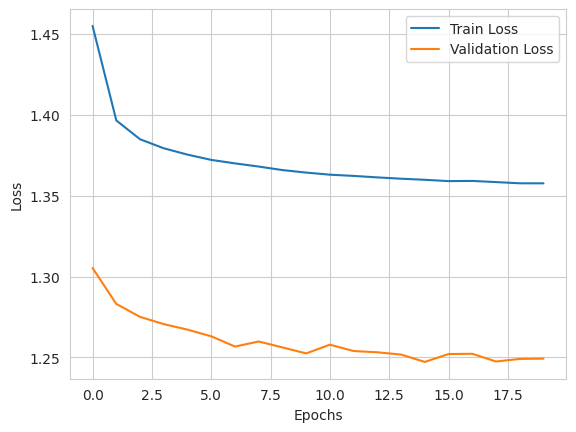

In [74]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [75]:
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert labels to one-hot encoding
y_onehot = to_categorical(y_train)

# Initialize StratifiedKFold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results
fold_accuracies = []

# Stratified Cross-Validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_onehot[train_idx], y_onehot[val_idx]
    
    # Build the model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
        Dropout(0.3),  # Dropout for regularization
        Dense(64, activation='relu'),  # Hidden layer
        Dropout(0.3),
        Dense(y_onehot.shape[1], activation='softmax')  # Output layer
    ])
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=5,  # Adjust epochs as needed
        batch_size=64,  # Adjust batch size as needed
        verbose=1
    )
    
    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold + 1} - Validation Accuracy: {val_accuracy:.4f}")
    
    # Store the accuracy for this fold
    fold_accuracies.append(val_accuracy)

# Print overall results
print(f"Mean Validation Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Validation Accuracy Standard Deviation: {np.std(fold_accuracies):.4f}")

Training fold 1/5...


/home/minorilabs/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
40669/40669 ━━━━━━━━━━━━━━━━━━━━ 167s 4ms/step - accuracy: 0.4371 - loss: 1.4823 - val_accuracy: 0.5079 - val_loss: 1.3206
Epoch 2/5
40669/40669 ━━━━━━━━━━━━━━━━━━━━ 165s 4ms/step - accuracy: 0.4690 - loss: 1.4074 - val_accuracy: 0.5187 - val_loss: 1.2926
Epoch 3/5
40669/40669 ━━━━━━━━━━━━━━━━━━━━ 158s 4ms/step - accuracy: 0.4752 - loss: 1.3922 - val_accuracy: 0.5194 - val_loss: 1.2764
Epoch 4/5
40669/40669 ━━━━━━━━━━━━━━━━━━━━ 160s 4ms/step - accuracy: 0.4783 - loss: 1.3850 - val_accuracy: 0.5228 - val_loss: 1.2757
Epoch 5/5
40669/40669 ━━━━━━━━━━━━━━━━━━━━ 158s 4ms/step - accuracy: 0.4805 - loss: 1.3790 - val_accuracy: 0.5277 - val_loss: 1.2721
Fold 1 - Validation Accuracy: 0.5277
Training fold 2/5...
Epoch 1/5
40669/40669 ━━━━━━━━━━━━━━━━━━━━ 163s 4ms/step - accuracy: 0.4386 - loss: 1.4787 - val_accuracy: 0.5070 - val_loss: 1.3188
Epoch 2/5
40669/40669 ━━━━━━━━━━━━━━━━━━━━ 161s 4ms/step - accuracy: 0.4725 - loss: 1.4016 - val_accuracy: 0.5232 - val_loss: 1.2904
Epoch 3/5
4

In [39]:
import pandas as pd

# Load a CSV file (e.g., 1.csv)
df_sample = pd.read_csv('../data/1.csv', header=None, names=['seq', 'x', 'y', 'z', 'label'])

# Extract the first 104 rows as a sample window
sample_window = df_sample.head(500)

# Save only the features (x, y, z) to sample_window.csv
sample_window[['x', 'y', 'z']].to_csv('sample_window.csv', index=False)

In [38]:
sample_window

,seq,x,y,z,label
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1
...,...,...,...,...,...
2995,2995.0,1978,2374,2124,1
2996,2996.0,1977,2375,2132,1
2997,2997.0,1977,2373,2126,1
2998,2998.0,1977,2371,2133,1
